In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import timedelta
import datetime as dt

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
pd.options.display.float_format = '{:,.2f}'.format

___

## Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Нам предстоит приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

В первой части работы мы ознакомимся с данными, предобработаем их и приоритизируем гипотезы из базы.
После этого мы проанализируем результаты тестирования, посмотрим как менялись конверсия и средний чек по группам. 

После этого проведем статистические тесты и примем решение об остановке/продолжении тестирования и сделаем выводы

___

**Данные для первой части**
Файл `/datasets/hypothesis.csv.`
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**
Файл `/datasets/orders.csv.`  
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv.` 
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

___

## Познакомимся с данными

In [3]:
dateparser = lambda x: pd.to_datetime(x)


try:
    data, orders, visitors = (
        pd.read_csv('hypothesis.csv'), 
        pd.read_csv('orders.csv', parse_dates=['date'], date_parser=dateparser),
        pd.read_csv('visitors.csv', parse_dates=['date'], date_parser=dateparser)
    )
except:
    data, orders, visitors = (
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'), 
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
    )

In [4]:
# Зададим функцию для первого ознакомления с данными
def research(df):
    df.columns = [col.lower().replace(' ','_') for col in df.columns]
    display(df.info())
    display(df.describe())
    print('Пропуски \n ', df.isna().sum())
    print('\n Дубликаты', df.duplicated().sum())
    display(df.head())

In [5]:
research(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,reach,impact,confidence,efforts
count,9.00,9.00,9.00,9.00
mean,4.78,4.78,5.56,4.89
std,3.15,3.19,3.05,2.80
min,1.00,1.00,1.00,1.00
25%,3.00,3.00,3.00,3.00
50%,3.00,3.00,7.00,5.00
75%,8.00,7.00,8.00,6.00
max,10.00,10.00,9.00,10.00


Пропуски 
  hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

 Дубликаты 0


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [6]:
research(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionid,visitorid,revenue
count,"1,197.00","1,197.00","1,197.00"
mean,"2,155,621,385.53","2,165,960,143.10","8,348.01"
std,"1,229,084,904.76","1,236,014,192.15","39,191.13"
min,"1,062,393.00","5,114,589.00",50.00
25%,"1,166,775,572.00","1,111,826,046.00","1,220.00"
50%,"2,145,193,898.00","2,217,984,702.00","2,978.00"
75%,"3,237,740,112.00","3,177,606,451.00","8,290.00"
max,"4,293,855,558.00","4,283,872,382.00","1,294,500.00"


Пропуски 
  transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

 Дубликаты 0


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
research(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,visitors
count,62.00
mean,607.29
std,114.40
min,361.00
25%,534.00
50%,624.50
75%,710.50
max,770.00


Пропуски 
  date        0
group       0
visitors    0
dtype: int64

 Дубликаты 0


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Вывод по данным

<div style="border:solid blue 2px; padding: 20px">
Данные изучены и предварительно предобработаны. 

    Были преведены названия колонок к нужному формату. Посмотрели на будликаты и пропуски в данных
    
    Теперь можно приступать к дальнейшим шагам по проекту

___

## Приоритезация гипотез

In [8]:
data.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


### ICE

Расставим приоритет гипотез по методу ICE

In [9]:
data['ICE'] = round(data['impact'] * data['confidence'] / data['efforts'], 2)
data[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Первая тройка по приоритету слудющая: "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

Также можно отметить, что гипотезы сформулированы весьма дурно. Например, "Запустить акцию, дающую скидку на товар в день рождения". Ради чего запускать данную акцию? Какой результат мы приследуем?

### RICE

Теперь приоритезируем гипотезы методом RICE

In [10]:
data['RICE'] = round(data['reach'] * data['impact'] * data['confidence'] / data['efforts'], 2)
data[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


<div style="border:solid blue 2px; padding: 20px">
Результаты несколько изменились. В частности,  "Запустить акцию, дающую скидку на товар в день рождения" вылетело из топ-3. Все дело в параметре reach, который показывает охват пользователей. Чем больше пользователей охватывает изменение, тем больше данный параметр, и, соответсвенно, тем больше итоговый балл

___

## Анализ A/B-теста

### Проверка данных

Для начала проверим: не "перемешаны" ли пользователи по группам. То есть нет ли пользователей, который попали в обе группы

In [11]:
df = (orders
      .pivot_table(index='visitorid', values='group', aggfunc='nunique')
      .reset_index()
      .query('group > 1')
     )
display(df.count())

visitorid    58
group        58
dtype: int64

Мы видим, что 58 пользователей попали в обе группы

Предлагаю убрать таких пользователей из датафрейма

In [12]:
# Список id перемешанных пользователей
wrong_id = df['visitorid'].to_list()

In [13]:
# Уберем их из датафрейма
orders = orders.query('visitorid not in @wrong_id')

In [14]:
# Проверим результат
df = (orders
      .pivot_table(index='visitorid', values='group', aggfunc='nunique')
      .reset_index()
      .query('group > 1')
     )
display(df.count())

visitorid    0
group        0
dtype: int64

Теперь перемешанных пользователей нет. 

In [15]:
orders.groupby('group')['visitorid'].nunique()

group
A    445
B    528
Name: visitorid, dtype: int64

Также нужно обратить внимание на то, что группы не равны по размеру. В будущем следует обратить на это внимание до проведения теста

### Подготовка данных для анализа

Подготовим данные для анализа A/B теста

In [16]:
# Уникальные пары значений дата-группа
datesGroups = orders[['date','group']].drop_duplicates() 

In [17]:
# Агрегируем значения для получения кумулятивного значения revenue по группам
ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                           orders['group'] == x['group'])]
                    .agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
                   )
ordersAggregated.head()

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [18]:
#  Агрегируем значения для получения кумулятивного значения полтзователей по группам
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                               visitors['group'] == x['group'])]
                      .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [19]:
# Объеденим датафреймы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [20]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

display(cumulativeRevenueA.head(5))

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

display(cumulativeRevenueB.head(5))

,date,revenue,orders
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


,date,revenue,orders
1,2019-08-01,59758,17
3,2019-08-02,221801,40
5,2019-08-03,288850,54
7,2019-08-04,385740,68
9,2019-08-05,475648,89


### График выручки по группам

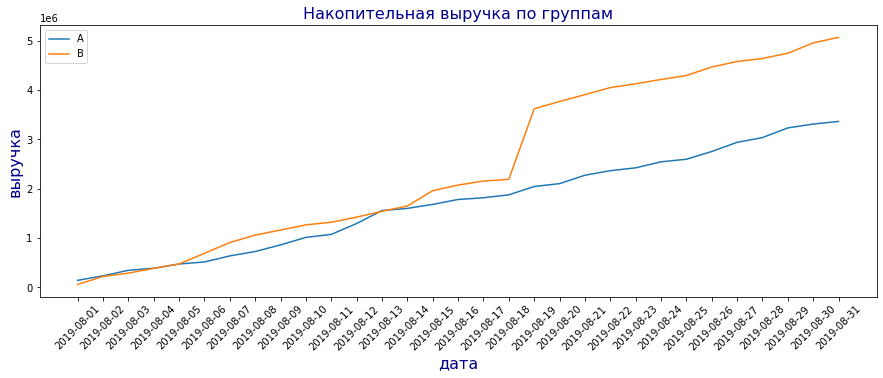

In [21]:
plt.figure(figsize=(15, 5))

# график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

font = {'color':  'darkblue',
        'size': 16,
        }


plt.legend();
plt.title('Накопительная выручка по группам', fontdict=font);
plt.xlabel('дата', fontdict=font);
plt.ylabel('выручка', fontdict=font);
plt.xticks(rotation=45);


<div style="border:solid blue 2px; padding: 20px">
Выручка группы B практически всегда больше, чем у группы A. Также можно заметить резкий скачок в середине августа. Вероятно, в этот день был совершен крупный заказ пользователем из группы B

### График среднего чека

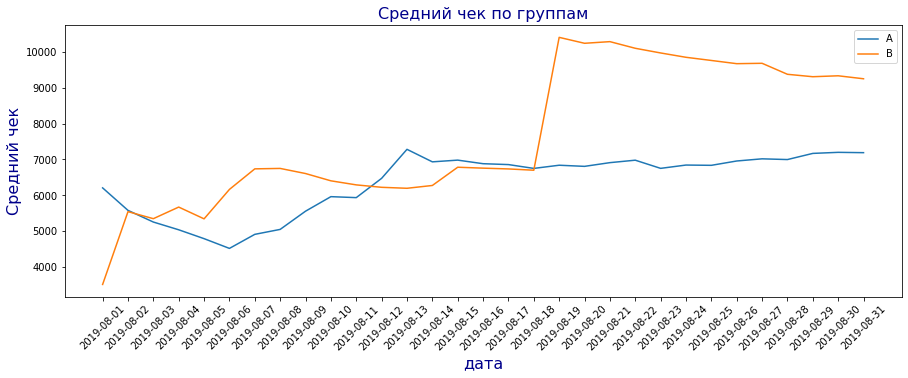

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend();
plt.title('Средний чек по группам', fontdict=font);
plt.xlabel('дата', fontdict=font);
plt.ylabel('Средний чек', fontdict=font);
plt.xticks(rotation=45);

<div style="border:solid blue 2px; padding: 20px">
Кумулятивное значение среднего чека весьма нестабильно. Здесь тоже можно отметить, что после 17го августа средний чек резко увеличился. Принимать решение по данной метрике явно не стоит. Значение для группы A после 13 августа "устаканилось" и находилось на отметке 6-7 тысяч

### Относительный прирост среднего чека

Чтобы лучше изучить разницу между группами, построим график прироста среднего чека группы B, относительно группы A

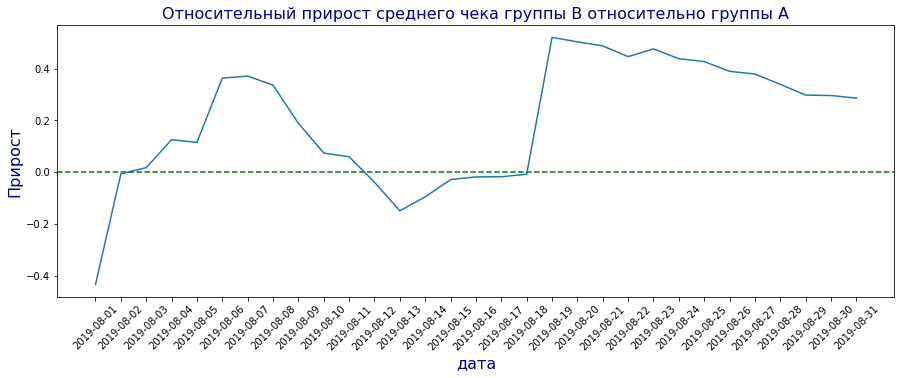

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='green', linestyle='--') 
plt.title('Относительный прирост среднего чека группы B относительно группы A', fontdict=font);
plt.xlabel('дата', fontdict=font);
plt.ylabel('Прирост', fontdict=font);
plt.xticks(rotation=45);

<div style="border:solid blue 2px; padding: 20px">
Результаты значительно менялись несколько раз. Скорее всего, в эти дни были совершены большие покупки. 

### Конверсия по группам

Предлагаю посмотреть на изменение конвесрий по группам. Это так же является важным показателем

In [24]:
# Считаем конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.03
1,2019-08-01,B,17,17,59758,713,0.02
2,2019-08-02,A,42,36,234381,1338,0.03
3,2019-08-02,B,40,39,221801,1294,0.03
4,2019-08-03,A,66,60,346854,1845,0.04


In [25]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

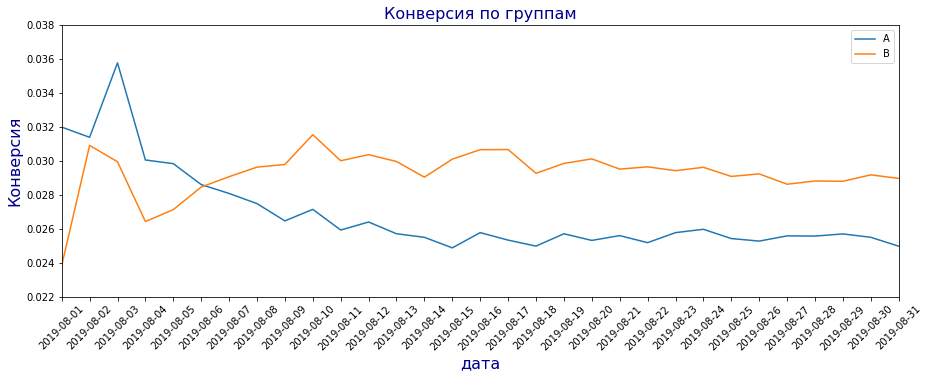

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.axis([cumulativeData['date'].min(), cumulativeData['date'].max(), 0.022, 0.038])
plt.legend()
plt.title('Конверсия по группам', fontdict=font);
plt.xlabel('дата', fontdict=font);
plt.ylabel('Конверсия', fontdict=font);
plt.xticks(rotation=45);

<div style="border:solid blue 2px; padding: 20px">
В самом начале тесат, конверсия группы A была больше. Но примерно 7 августа ситуация поменялась и конверсия группы B стала больше. Конверсия для группы A находилась примерно на отметке в 0.025Б а группы B - 0.03
Еще стоит отметить, что в целом график выглядит симметрично. 

### Относительный прирост конверсии

Для более детального изучения конверсии построим график относительного прироста конверсии группы B относительно группы A

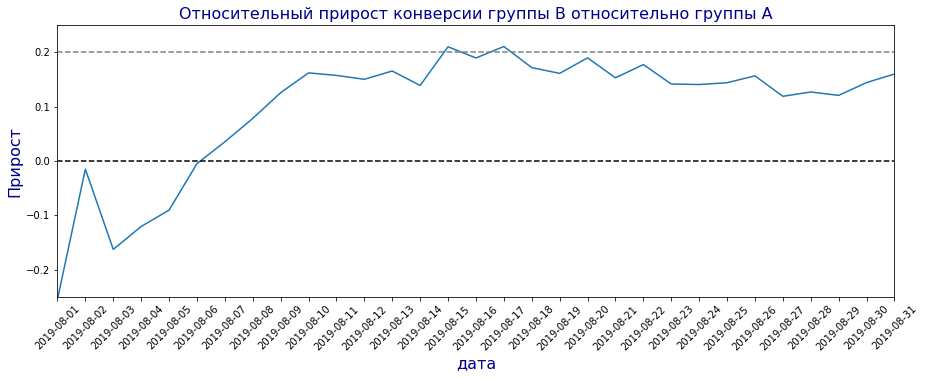

In [27]:
# Объединяем данные
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', 
                                      how='left', suffixes=['A', 'B'])
                            )
# Строим график  
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([cumulativeData['date'].min(), cumulativeData['date'].max(), -0.25, 0.25])
plt.title('Относительный прирост конверсии группы B относительно группы A', fontdict=font);
plt.xlabel('дата', fontdict=font);
plt.ylabel('Прирост', fontdict=font);
plt.xticks(rotation=45);

<div style="border:solid blue 2px; padding: 20px">
Здесь мы видим, что начиная примерно с 7го августа, конверсия группы B постоянно превосзодила конвесию группы A в среднем на 0.1 - 0.2. В середине агуста относительный прирост даже превышал 0.2

### Поиск аномальных значений

В данном пункте построим точечные графики по числу заказов по пользователям и по сумме заказов. посчитаем 95 и 99й процентили. Это понадобится нам при последующем проведении теста. 

In [28]:
orders_by_user = (orders
                  .groupby('visitorid', as_index=False)
                  ['transactionid'].nunique()
                  .sort_values('transactionid', ascending=False)
                 )
orders_by_user

,visitorid,transactionid
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


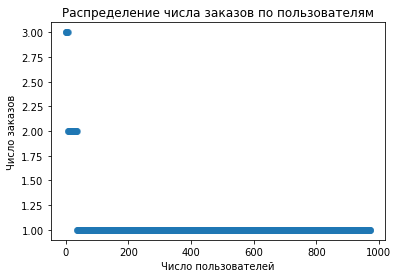

In [29]:
x_values = pd.Series(range(0, len(orders_by_user)))


plt.scatter(x_values, orders_by_user['transactionid'], alpha=0.5)  
plt.title('Распределение числа заказов по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Число заказов')
plt.show()

In [30]:
np.percentile(orders_by_user['transactionid'], [95, 99])

array([1., 2.])

Не более чем у 1% пользователей более 2 заказов. Почти у всех пользователей по 1 заказу

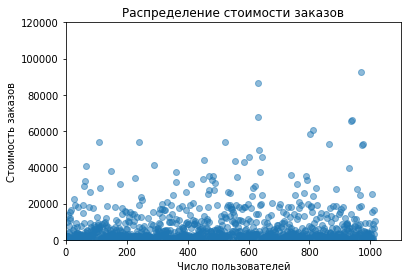

In [31]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'], alpha=0.5) 

plt.title('Распределение стоимости заказов')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.axis([0, 1100, 0, 120000])

plt.show()

In [32]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более, чем у 5% пользователей сумма заказа более 26,7 тыс. руб. Не более, чем у 1% пользователей сумма заказа более 53,9 тыс. руб

<div style="border:solid blue 2px; padding: 20px">
Поиск аномалий очень важный этап в анализе результатов A/B тестирования. В данном пункте мы нашли аномалии для числа заказов и для суммы заказов

___

## Тест

### Подготовка данных

Подготовим данные для проведения стат теста:
- Подсчитаем кол-во посетитлей в день по группам
- Подсчитаем кол-во заказов в день по группам
- Соберем общий датафрейм для проведения тестов

In [33]:
check_group = (orders
      .pivot_table(index='visitorid', values='group', aggfunc='nunique')
      .reset_index()
     )
check_group.query('group > 1')

,visitorid,group


In [34]:
# Подсчитаем посетителей в день для группы А (+ нарастающим итогом)
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [35]:
# Подсчитаем посетителей в день для группы B (+ нарастающим итогом)
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [36]:
# Подсчитаем кол-во заказов в день для группы A ( + нарастающим итогом)
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,19,142779
1,2019-08-02,37,234381
2,2019-08-03,61,346854
3,2019-08-04,72,388030
4,2019-08-05,94,474413


In [37]:
# Подсчитаем кол-во заказов в день для группы B (+ нарастающим итогом)
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,17,59758
1,2019-08-02,39,221801
2,2019-08-03,53,288850
3,2019-08-04,66,385740
4,2019-08-05,87,475648


In [38]:
# Объединим данные
df = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

df.head(10)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,19,142779,17,59758,19,142779,17,59758,719,713,719,713
1,2019-08-02,18,91602,22,162043,37,234381,39,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,61,346854,53,288850,507,509,1845,1803
3,2019-08-04,11,41176,13,96890,72,388030,66,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,94,474413,87,475648,756,707,3318,3280
5,2019-08-06,12,40919,22,214842,106,515332,109,690490,667,655,3985,3935
6,2019-08-07,16,123248,23,219164,122,638580,132,909654,644,709,4629,4644
7,2019-08-08,14,88639,22,150141,136,727219,154,1059795,610,654,5239,5298
8,2019-08-09,11,134237,19,103166,147,861456,173,1162961,617,610,5856,5908
9,2019-08-10,15,152275,22,105162,162,1013731,195,1268123,406,369,6262,6277


### Сравнение конверсий групп по сырым данным

Сравним конверсии групп по сырым данным. Будем использовать непараметрический тест Манна-Уитни

In [39]:
# Создадим переменные для количества заказов по пользователям группы A
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'transactionid']

# Создадим переменные для количества заказов по пользователям группы B
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'transactionid'] 

In [40]:
sampleA = (pd.concat([ordersByUsersA['transactionid'],
                    pd.Series(0, index=np.arange(df['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionid'])), 
                    name='transactionid')],axis=0)
          )

sampleB = (pd.concat([ordersByUsersB['transactionid'],
                      pd.Series(0, index=np.arange(df['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionid'])),
                      name='transactionid')],axis=0)
          ) 

Проверим выборки критерием Манна-Уитни и выведем относительный прирост конверсии группы B
- Н0 - Статистически значимых различий в конверсии между группами нет
- Н1 - Статистически значимые различия в конверсии между группами есть

Поскольку тест двусторонний, добавим параметр `alternative = 'two-sided'`

In [41]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


<div style="border:solid blue 2px; padding: 20px">
Значение p-value 0.011, что меньше уровня значимости в 5%
    
    
Нулевую гипотезу отвергаем. Относительное изменение конверсии группы B равно 16%. 

### Сравнение среднего чека по сырым данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- H0 - Статистически значинмых различий в среднем чеке нет
- H1 - Статистически значимые различия в среднем чеке есть

In [42]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


<div style="border:solid blue 2px; padding: 20px">
В данном случае отвергнуть нулевую гипотезу нельзя. При этом относительный прирост группы среднего чека группы B равен почти 29% (!). Это весьма необычно. Посмотрим какие будут результаты после очистки данных. 

### Очистка данных

Теперь очистим данные и повторим рассчеты. 

За аномальное количество заказов примем 2, а за аномальную сумму заказа примем 27000

In [43]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactionid'] > 1]['visitorid'],
        ordersByUsersB[ordersByUsersB['transactionid'] > 1]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 27000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
print('Количество аномальных пользователей:' ,abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorid, dtype: int64

Количество аномальных пользователей: 86


Очистили данные и выяснили кол-во "аномальных" пользователей. Теперь посмотрим как очистка данных повлияет на результаты теста

In [44]:
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['transactionid'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionid'])
            ),
            name='transactionid',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['transactionid'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionid'])
            ),
            name='transactionid',
        ),
    ],
    axis=0,
) 

### Сравнение конверсий по очищенным данным

- H0 - После очистки данных статистически значимых различий в конверсиях между группами нет
- Н1 - После очистки данных статистически значимые различия в конверсиях между группами есть

In [45]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.016
0.174


<div style="border:solid blue 2px; padding: 20px">
Как и в случае с сырыми данными, мы вынуждены отвергнуть нулевую гипотезу. Относительный прирост немного увеличился и составил 17,4%

### Сравнение среднего чека по очищенным данным

Теперь посмотрим на статистические различия между средним чекам по группам. Также посмотрим относительный прирост. 
Сформулируем гиппотезы
- H0 - После очистки данных статистически значимых различий в средних чеках между группами нет
- Н1 - После очистки данных статистически значимые различия в средних чеках между группами есть

In [46]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.727
-0.034


<div style="border:solid blue 2px; padding: 20px">
Отвергнуть нулевую гипотезу нельзя, однако относительный прирост среднего чека теперь составил всего 3%. Значит, все дело было в аномально большом заказе. Из-за этого в сырых данных мы получили почти 29%

<div style="border:solid blue 2px; padding: 20px">
Анализируя полученные результаты и независимо от того, что по среднему чеку статистической значимости не обнаружено, считаю нужным остановить тест и зафиксировать победу группы В. 
Группа B статистически значимо лучше группы A по метрике конверсии, но статистических различий в средних чеках нет. 
Поскольку задача стояла в эффективности гипотезы по увеличению выручки, нужно смотреть на конверсию. 
Выручка не всегда показывает положительную или отрицательную динамику, точнее сложно понять по выручке, без учета числа покупателей.

___

## Итоги

Мы провели глубокий анализ результатов A/B тестирования для интернет-магазина.

В нашем распоряжении были данные о заказ интрнет-магазина за август 2019 года. 

Для начала мы познакомились с данными, провели их предобработку. После этого мы приоритезировали гипотезы , которые содержались в базе, двумя способами и сравнили полученные результаты. Далее построили графики и проанализировали группы по среднему чеку и конверсии. Также посмотрели на относительные приросты данных показателей. 

В конце работы мы проверили статистические и приняли решение остановить тестирование и признать его успешным. В данной работе отчетливо было видно, что очистка данных оказывает большое влияние на результаты. Без очистки данных результаты могли быть другими, ведь относительный прирост среднего чека был намного больше, чем после очистки. 
Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий, но разница между сегментами сократилась с 29% до 3%.